In [2]:
import sqlite3
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
import scikitplot as skplt
from sklearn import tree
from sklearn.preprocessing import RobustScaler 
from sklearn import svm

In [4]:
connection = sqlite3.connect("museum_list.db") 
crsr = connection.cursor()
sql_command = """SELECT * FROM museum;"""
crsr.execute(sql_command)
myresult = crsr.fetchall()
x = []
y = []
for row in myresult:
    x.append(row[4])
    y.append(row[2])
x = np.asarray(x).reshape(-1,1)
y = np.asarray(y)

## Data Stats

In [3]:
print("Mean of input: ", x.mean())
print("Mean of output: ", y.mean())
print("Variance of input: ", x.var())

Mean of input:  12701781.37704918
Mean of output:  3552321.8524590163
Variance of input:  55045539245869.02


# Plot the Box plot to see the distribution and show the outliers

{'whiskers': [<matplotlib.lines.Line2D at 0x124065cf8>,
 'caps': [<matplotlib.lines.Line2D at 0x1240813c8>,
 'boxes': [<matplotlib.lines.Line2D at 0x124065908>],
 'medians': [<matplotlib.lines.Line2D at 0x124081a58>],
 'fliers': [<matplotlib.lines.Line2D at 0x124081da0>],
 'means': []}

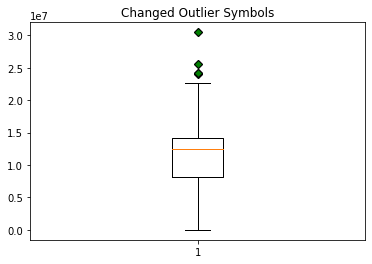

In [4]:
green_diamond = dict(markerfacecolor='g', marker='D')
fig3, ax3 = plt.subplots()
ax3.set_title('Changed Outlier Symbols')
ax3.boxplot(x, flierprops=green_diamond)

# Split the data

In [5]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
print("# training examples: ",len(X_train))
print("# valid examples: ",len(X_val))
print("# test examples: ",len(X_test))

# training examples:  36
# valid examples:  12
# test examples:  13


#  Scale the data

In [6]:
transformer = RobustScaler().fit(X_train)

#transformed_X_train = transformer.transform(X_train)
#transformed_X_val = transformer.transform(X_val)
#transformed_X_test = transformer.transform(X_test)

transformed_X_train = X_train/10000
transformed_X_val = X_val/10000
transformed_X_test = X_test/10000


transformed_y_train = y_train/10000
transformed_y_val = y_val/10000
transformed_y_test = y_test/10000

Before scaling..


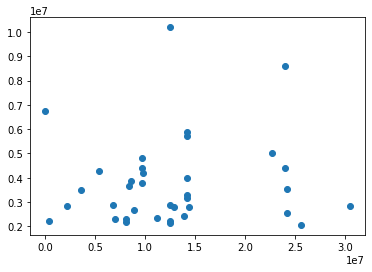

In [7]:
fig, ax = plt.subplots()
print("Before scaling..")
ax.scatter(X_train, y_train)

After scaling..


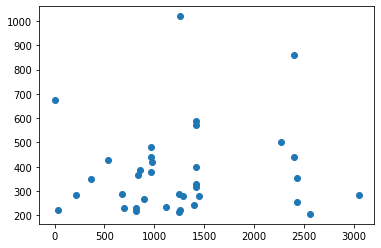

In [8]:
fig, ax = plt.subplots()
print("After scaling..")
ax.scatter(transformed_X_train, transformed_y_train)

In [9]:
def generate_poly_features(x, degree):
    features = []
    for i in range(degree):
        features.append(x**(i+1))
    
    return np.concatenate(features, axis=1)

## Linear Regression

In [10]:
def regressor(model, X_train, y_train, X_val, y_val, X_test, y_test, step, degree):

    xmin = min(X_train)
    xmax = max(X_train)
    xx = np.arange(xmin,xmax, step).reshape(-1,1)
    fig, ax = plt.subplots()
    ax.scatter(X_train, y_train, edgecolors=(0, 0, 0))

    X_train_feats = generate_poly_features(X_train, degree)
    X_val_feats = generate_poly_features(X_val, degree)
    X_test_feats = generate_poly_features(X_test, degree)


    model.fit(X_train_feats, y_train)
    prediction_linear_train = model.predict(X_train_feats)
    prediction_linear_valid = model.predict(X_val_feats)
    
    train_error = mean_squared_error(y_train, prediction_linear_train)
    val_error = mean_squared_error(y_val, prediction_linear_valid)

    print("Mean Squared error of training data when feature x is used: ", train_error)
    print("Mean squared error of validation data when feature x is used: ", val_error)

    yy_linear = model.predict(generate_poly_features(xx, degree))

    ax.plot(xx,yy_linear)


    #ax.legend(['trained with x', 'trained with x^2', 'trained with x^3', 'trained with sqrt(x)'])


    plt.title("Linear Regression")
    plt.xlabel("Population of City")
    plt.ylabel("Number of Visitors")
    plt.show()
    return train_error, val_error




Mean Squared error of training data when feature x is used:  2216382045341.941
Mean squared error of validation data when feature x is used:  2482774867889.982


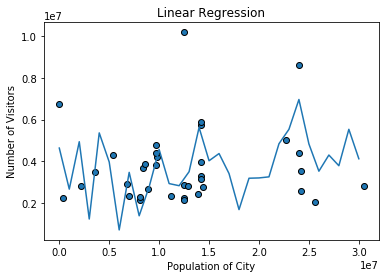

(2216382045341.941, 2482774867889.982)

In [11]:
regressor(LinearRegression(), X_train, y_train, X_val, y_val, X_test, y_test, 1000000, 10)

In [12]:
def model_selection(model, X_train, y_train, X_val, y_val, X_test, y_test, step):
    
    best_val = float('Inf')
    best_deg = 100
    
    for degree in range(1,10):
        if model == "linear regression":
            model = LinearRegression()
        elif model == "DT":
            print("hi")
            model = tree.DecisionTreeRegressor()
        elif model == "SVR":
            model = svm.SVR(kernel="linear")
        tr, val = regressor(model, X_train, y_train, X_val, y_val, X_test, y_test, step, degree)
        print(tr,val)
        if val < best_val:
            best_val = val
            best_deg = degree
    print("best degree: ", best_deg)
    print("best val error: ", best_val)

Mean Squared error of training data when feature x is used:  31920.93377714522
Mean squared error of validation data when feature x is used:  19559.942259028187


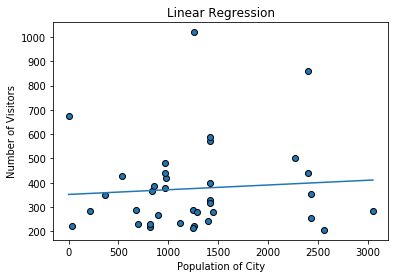

31920.93377714522 19559.942259028187
Mean Squared error of training data when feature x is used:  31907.971101831128
Mean squared error of validation data when feature x is used:  19082.243156507557


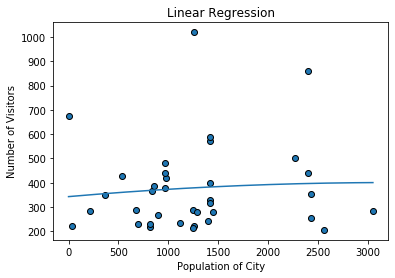

31907.971101831128 19082.243156507557
Mean Squared error of training data when feature x is used:  29820.38941541175
Mean squared error of validation data when feature x is used:  25496.38754673733


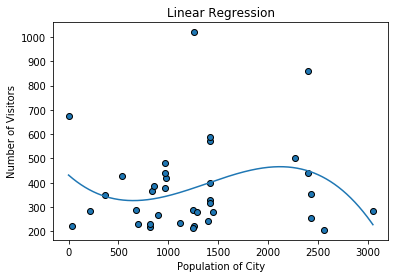

29820.38941541175 25496.38754673733
Mean Squared error of training data when feature x is used:  29594.915490988395
Mean squared error of validation data when feature x is used:  25899.623221911777


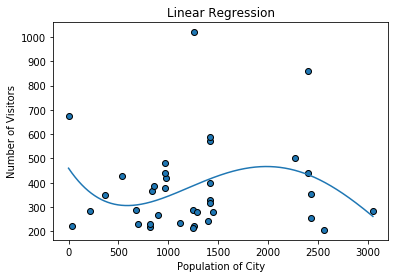

29594.915490988395 25899.623221911777
Mean Squared error of training data when feature x is used:  29593.67579758248
Mean squared error of validation data when feature x is used:  25799.564126825568


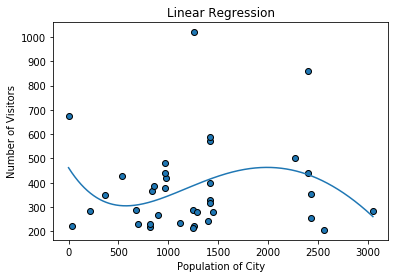

29593.67579758248 25799.564126825568
Mean Squared error of training data when feature x is used:  29534.39283992519
Mean squared error of validation data when feature x is used:  29489.025490686647


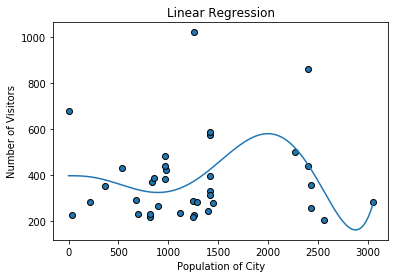

29534.39283992519 29489.025490686647
Mean Squared error of training data when feature x is used:  29146.368963954057
Mean squared error of validation data when feature x is used:  30861.752106546763


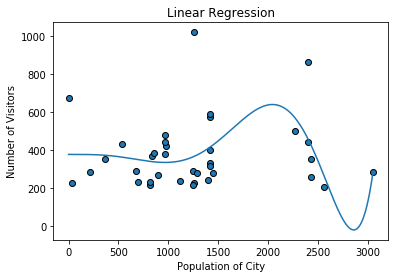

29146.368963954057 30861.752106546763
Mean Squared error of training data when feature x is used:  28983.826695202348
Mean squared error of validation data when feature x is used:  29035.700610828353


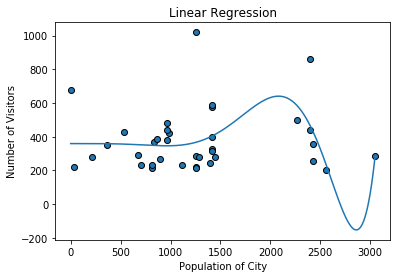

28983.826695202348 29035.700610828353
Mean Squared error of training data when feature x is used:  28906.34172610581
Mean squared error of validation data when feature x is used:  27414.58171147094


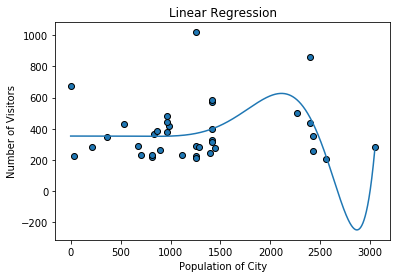

28906.34172610581 27414.58171147094
best degree:  2
best val error:  19082.243156507557


In [13]:
model_selection("linear regression", transformed_X_train, transformed_y_train,
          transformed_X_val, transformed_y_val,transformed_X_test, transformed_y_test, 0.01)

## Decision Tree

hi
Mean Squared error of training data when feature x is used:  13563.26141714199
Mean squared error of validation data when feature x is used:  40990.2706012137


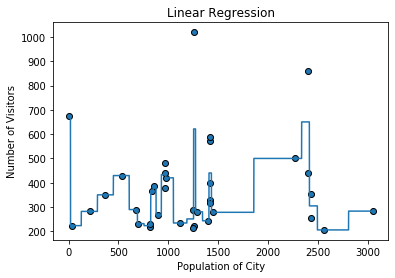

13563.26141714199 40990.2706012137
Mean Squared error of training data when feature x is used:  13563.26141714199
Mean squared error of validation data when feature x is used:  40990.2706012137


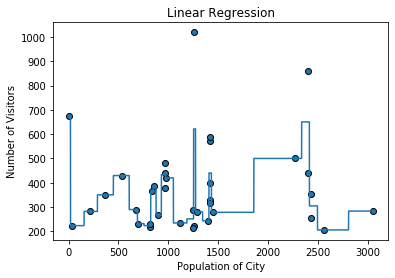

13563.26141714199 40990.2706012137
Mean Squared error of training data when feature x is used:  13563.261417141992
Mean squared error of validation data when feature x is used:  40990.270601213706


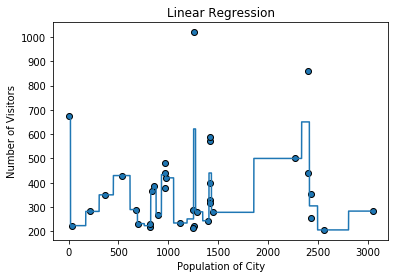

13563.261417141992 40990.270601213706
Mean Squared error of training data when feature x is used:  13563.26141714199
Mean squared error of validation data when feature x is used:  35921.2706012137


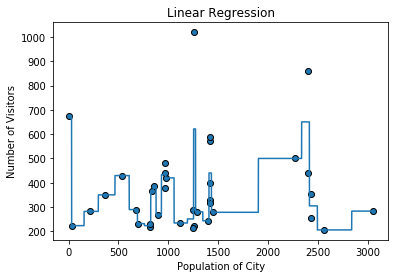

13563.26141714199 35921.2706012137
Mean Squared error of training data when feature x is used:  13563.26141714199
Mean squared error of validation data when feature x is used:  35921.2706012137


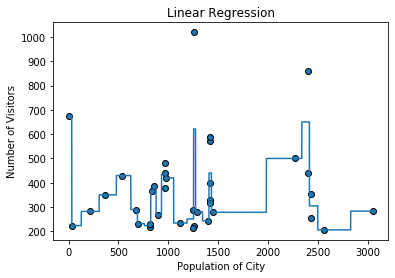

13563.26141714199 35921.2706012137
Mean Squared error of training data when feature x is used:  13563.26141714199
Mean squared error of validation data when feature x is used:  35921.2706012137


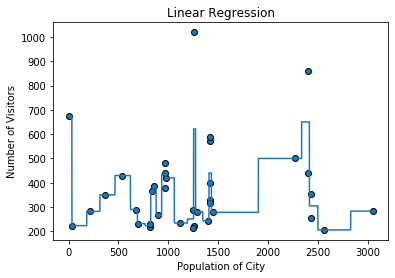

13563.26141714199 35921.2706012137
Mean Squared error of training data when feature x is used:  13563.26141714199
Mean squared error of validation data when feature x is used:  35921.2706012137


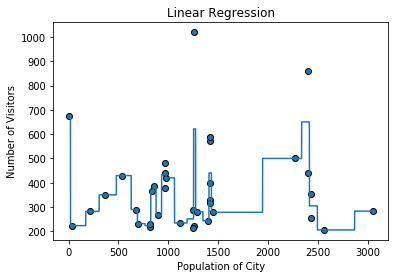

13563.26141714199 35921.2706012137
Mean Squared error of training data when feature x is used:  13563.261417141992
Mean squared error of validation data when feature x is used:  35921.270601213706


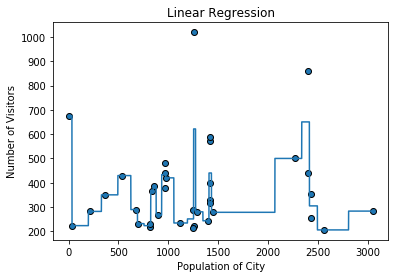

13563.261417141992 35921.270601213706
Mean Squared error of training data when feature x is used:  13563.26141714199
Mean squared error of validation data when feature x is used:  35921.2706012137


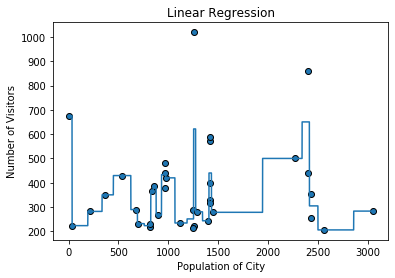

13563.26141714199 35921.2706012137
best degree:  4
best val error:  35921.2706012137


In [14]:
model_selection("DT", transformed_X_train, transformed_y_train,
          transformed_X_val, transformed_y_val,transformed_X_test, transformed_y_test, 0.01)

Mean Squared error of training data when feature x is used:  35626.43180485364
Mean squared error of validation data when feature x is used:  21736.841972849586


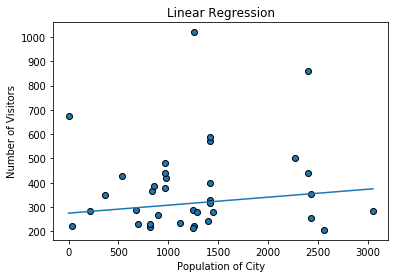

35626.43180485364 21736.841972849586
Mean Squared error of training data when feature x is used:  61731269741.09762
Mean squared error of validation data when feature x is used:  22531402596.28347


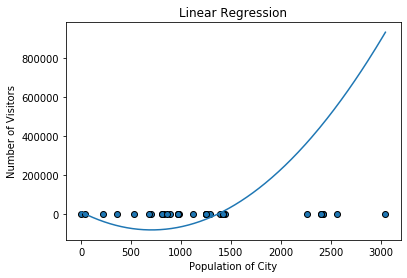

61731269741.09762 22531402596.28347


In [ ]:
model_selection("SVR", transformed_X_train, transformed_y_train,
          transformed_X_val, transformed_y_val,transformed_X_test, transformed_y_test, 0.01)